In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import log
from sklearn.model_selection import train_test_split

In [128]:
# 原文链接：https://blog.csdn.net/colourful_sky/article/details/82056125

In [107]:
# 决策树的训练构建
currentLabel = featVec[-1] # 表示最后一列
        # 当前标签不在labelCounts map中，就让labelCounts加入该标签
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] =0
        labelCounts[currentLabel] +=1

    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob,2) # log 

In [108]:
def createDataSet():
    X = pd.read_csv(r"C:\Users\Tianh\Desktop\DMLab\data\car_data.csv",header = None)
#     print(X.shape)
#     X.head()
    
    X = np.array(X)
    
    le = preprocessing.LabelEncoder()
    le.fit(["vhigh","high","med","low"])
    le1 = preprocessing.LabelEncoder()
    le1.fit(["big","med","small"])
    le2 = preprocessing.LabelEncoder()
    le2.fit(["vgood","good","acc","unacc"])
    
    X[:,0] = le.transform(X[:,0])
    X[:,1] = le.transform(X[:,1])
    X[:,4] = le1.transform(X[:,4])
    X[:,5] = le.transform(X[:,5])
    X[:,6] = le2.transform(X[:,6])
    
    for i in range(len(X)):
        if X[i,2] == '5more':
            X[i,2] = 5
        if X[i,3] == 'more':
            X[i,3] = 5
        
    x = X[:,0:6].astype(np.int32)
    y = X[:,6].astype(np.int32)
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
    
    y_train = y_train.reshape(1382,1)
    y_test = y_test.reshape(346,1)
    dataSet_train = np.hstack((x_train,y_train))
    dataSet_train = list(dataSet_train)
    dataSet_test = np.hstack((x_test,y_test))
    dataSet_test = list(dataSet_test)
    featureName = ['buying','maint','doors','persons','lug_boot','safety']
    # 返回数据集和每个维度的名称
    return dataSet_train ,dataSet_test, featureName

In [109]:
def splitDataSet(dataSet,axis,value):
    """
    按照给定特征划分数据集
    :param axis:划分数据集的特征的维度
    :param value:特征的值
    :return: 符合该特征的所有实例（并且自动移除掉这维特征）
    """

    # 循环遍历dataSet中的每一行数据
    
    retDataSet = []
    for featVec in dataSet:
        featVec = list(featVec)
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis] # 删除这一维特征
#             print(featVec)
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

In [110]:
##计算信息熵
# 计算的始终是类别标签的不确定度
def calcShannonEnt(dataSet):
    """
    计算训练数据集中的Y随机变量的香农熵
    :param dataSet:
    :return:
    """
    numEntries = len(dataSet) # 实例的个数
    labelCounts = {}
    for featVec in dataSet: # 遍历每个实例，统计标签的频次
        currentLabel = featVec[-1] # 表示最后一列
        # 当前标签不在labelCounts map中，就让labelCounts加入该标签
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] =0
        labelCounts[currentLabel] +=1

    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob,2) # log base 2
    return shannonEnt

In [111]:
## 计算条件熵
def calcConditionalEntropy(dataSet,i,featList,uniqueVals):
    """
    计算x_i给定的条件下，Y的条件熵
    :param dataSet: 数据集
    :param i: 维度i
    :param featList: 数据集特征列表
    :param unqiueVals: 数据集特征集合
    :return: 条件熵
    """
    ce = 0.0
    for value in uniqueVals:
        subDataSet = splitDataSet(dataSet,i,value)
        prob = len(subDataSet) / float(len(dataSet)) # 极大似然估计概率
        ce += prob * calcShannonEnt(subDataSet) #∑pH(Y|X=xi) 条件熵的计算 
    return ce

In [112]:
##计算信息增益
def calcInformationGain(dataSet,baseEntropy,i):
    """
    计算信息增益
    :param dataSet: 数据集
    :param baseEntropy: 数据集中Y的信息熵
    :param i: 特征维度i
    :return: 特征i对数据集的信息增益g(dataSet | X_i)
    """
    featList = [example[i] for example in dataSet] # 第i维特征列表
    uniqueVals = set(featList) # 换成集合 - 集合中的每个元素不重复
    newEntropy = calcConditionalEntropy(dataSet,i,featList,uniqueVals)#计算条件熵，
    infoGain = baseEntropy - newEntropy # 信息增益 = 信息熵 - 条件熵
    return infoGain

In [113]:
## 算法框架
def chooseBestFeatureToSplitByID3(dataSet):
    """
    选择最好的数据集划分
    :param dataSet:
    :return:
    """
    numFeatures = len(dataSet[0]) -1 # 最后一列是分类
    baseEntropy = calcShannonEnt(dataSet) #返回整个数据集的信息熵
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures): # 遍历所有维度特征
        infoGain = calcInformationGain(dataSet,baseEntropy,i) #返回具体特征的信息增益
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature # 返回最佳特征对应的维度

In [114]:
def createTree(dataSet,featureName,chooseBestFeatureToSplitFunc = chooseBestFeatureToSplitByID3):
    """
    创建决策树
    :param dataSet: 数据集
    :param featureName: 数据集每一维的名称
    :return: 决策树
    """
    classList = [example[-1] for example in dataSet] # 类别列表
    if classList.count(classList[0]) == len(classList): # 统计属于列别classList[0]的个数
        return classList[0] # 当类别完全相同则停止继续划分
    if len(dataSet[0]) ==1: # 当只有一个特征的时候，遍历所有实例返回出现次数最多的类别
        return majorityCnt(classList) # 返回类别标签
    bestFeat = chooseBestFeatureToSplitFunc(dataSet)#最佳特征对应的索引
    bestFeatLabel = featureName[bestFeat] #最佳特征
    myTree ={bestFeatLabel:{}}  # map 结构，且key为featureLabel
    del (featureName[bestFeat])
    # 找到需要分类的特征子集
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = featureName[:] # 复制操作
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels)
    return myTree

In [115]:
dataSet_train,dataSet_test,featureName = createDataSet()
# print(type(dataSet))
myTree = createTree(dataSet_train,featureName)
print(myTree)

{'safety': {0: {'persons': {2: 2, 4: {'buying': {0: {'maint': {0: 0, 1: 0, 2: 0, 3: 2}}, 1: {'maint': {0: {'lug_boot': {0: 3, 1: {'doors': {2: 0, 3: 0, 4: 3, 5: 3}}, 2: 0}}, 1: {'lug_boot': {0: 3, 1: {'doors': {3: 1, 4: 3, 5: 3}}, 2: 1}}, 2: {'lug_boot': {0: 3, 1: 1, 2: 1}}, 3: 0}}, 2: {'maint': {0: 0, 1: {'lug_boot': {0: 3, 1: {'doors': {2: 1, 3: 1, 4: 3, 5: 3}}, 2: 1}}, 2: {'lug_boot': {0: 3, 1: {'doors': {2: 0, 4: 3}}, 2: 0}}, 3: 0}}, 3: {'maint': {0: 2, 1: 0, 2: 0, 3: 2}}}}, 5: {'buying': {0: {'maint': {0: 0, 1: 0, 2: {'doors': {2: 2, 3: 0, 4: 0, 5: 0}}, 3: 2}}, 1: {'maint': {0: {'lug_boot': {0: 3, 1: {'doors': {2: 0, 5: 3}}, 2: {'doors': {2: 2, 3: 0, 5: 0}}}}, 1: {'lug_boot': {0: 3, 1: {'doors': {2: 1, 3: 3, 4: 3, 5: 3}}, 2: 1}}, 2: {'lug_boot': {0: 3, 1: 3, 2: {'doors': {2: 2, 3: 1, 5: 1}}}}, 3: {'doors': {2: {'lug_boot': {0: 0, 2: 2}}, 3: 0, 4: 0, 5: 0}}}}, 2: {'maint': {0: {'doors': {2: 2, 3: 0, 4: 0, 5: 0}}, 1: {'lug_boot': {0: 3, 1: {'doors': {2: 1, 3: 3, 4: 3, 5: 3}}, 2: {'d

In [116]:
# 决策树的可视化

In [117]:
import matplotlib.pyplot as plt

In [118]:
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="round4", color='#3366FF')  #定义判断结点形态
leafNode = dict(boxstyle="circle", color='#FF6633')  #定义叶结点形态
arrow_args = dict(arrowstyle="<-", color='g')  #定义箭头

In [119]:
#绘制带箭头的注释
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

In [120]:
#计算叶结点数
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [121]:
#计算树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [122]:
#在父子结点间填充文本信息
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [123]:
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)  #在父子结点间填充文本信息
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  #绘制带箭头的注释
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

In [124]:
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW;
    plotTree.yOff = 1.0;
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

In [125]:
# 决策树的绘制主文件

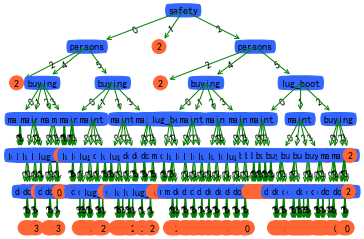

In [127]:
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

createPlot(myTree)